In [50]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, f1_score, r2_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score
import itertools
import joblib
import time
import json

In [51]:
model_info = {
    'model_name': 'Cost Effective Random Forest',
    'training_file': 'MLM_Random_Forest.ipynb',
    'file_name': 'model_rf.pkl',
    'prepared_by': 'Digital Khalid',
    'library': 'Scikit-Learn',
    'classifier': 'Random Forest Classifier',
    'normalization': 'Standard Scaler (Z-Score)',
    'data_file': 'flows.csv',
    'features': ['src_port', 'dst_port', 'protocol', 'first_pkt_size'],
    'target': ['elephant'],
}

In [52]:
# Save model information as json file
with open(f'model_info_{model_info["model_name"]}.json', "w") as outfile:
    json.dump(model_info, outfile)

In [41]:
# Read data file
input_file = model_info['data_file']
flows = pd.read_csv(input_file)

In [42]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [45]:
print(f'Features (X)\n{X}')

Features (X)
         src_port  dst_port  protocol  first_pkt_size
0            1999     54524         6              66
1               0         0         1              70
2           50005      3479        17             183
3           44734       443         6              54
4           43332      3128         6              54
...           ...       ...       ...             ...
1815567        80     12256         6              66
1815568         0         0         1              60
1815569         0         0         1              60
1815570     44843      2375         6              54
1815571     50355     43527         6              58

[1815572 rows x 4 columns]


In [46]:
print(f'Target (y)\n{y}')

Target (y)
         elephant
0               0
1               1
2               1
3               0
4               0
...           ...
1815567         0
1815568         0
1815569         0
1815570         0
1815571         0

[1815572 rows x 1 columns]


In [7]:
# Data Normalization
scaler = StandardScaler()

# Fit the scaler on the training set and transform the training set
X_norm = scaler.fit_transform(X)
X_norm

array([[-1.12855247,  2.33484912, -0.03448554, -0.10347916],
       [-1.21438915, -0.67620185, -1.34265272, -0.05961682],
       [ 0.9328159 , -0.48407643,  2.84348226,  1.17949415],
       ...,
       [-1.21438915, -0.67620185, -1.34265272, -0.16927266],
       [ 0.71116062, -0.54504408, -0.03448554, -0.23506616],
       [ 0.94784484,  1.72754724, -0.03448554, -0.19120383]])

In [8]:
flows['elephant'].value_counts()/ flows.shape[0] * 100

0    99.904823
1     0.095177
Name: elephant, dtype: float64

### Random Forest

In [10]:
# define model
model = RandomForestClassifier(class_weight='balanced')

In [11]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
scores = cross_val_score(model, X_norm, y, scoring='roc_auc', cv=cv, n_jobs=-4, verbose=3)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.


In [54]:
np.mean(scores)

0.5613046076671847

### Random Forest (Using multiple class weights and hyperparameters with Grid Search CV)

In [9]:
# define model
model = RandomForestClassifier()

In [11]:
# define hyperparameters
n_estimators = [50, 100]
class_weight = [{0:1,1:1500}, {0:1,1:999}]
max_depth = [5, 10]
min_samples_split = [5, 10]
min_samples_leaf = [5, 10]
criterion = ['gini', 'entropy']
bootstrap = [True, False]

param_grid = {
    'n_estimators': n_estimators,
    'class_weight': class_weight,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'criterion': criterion,
    'bootstrap': bootstrap,
}

In [12]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-3, cv=cv, scoring='roc_auc', verbose=2)

In [ ]:
# execute the grid search
start_time = time.time()

grid_result = grid.fit(X_norm, y)

runtime = time.time() - start_time
print(f'Runtime: {runtime} Seconds')

Fitting 9 folds for each of 128 candidates, totalling 1152 fits


In [76]:
# report the best configuration
print()
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.970502 using {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'splitter': 'best'}
0.945225 (0.006528) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5, 'splitter': 'best'}
0.878954 (0.017125) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5, 'splitter': 'random'}
0.945225 (0.006528) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10, 'splitter': 'best'}
0.879403 (0.019888) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10, 'splitter': 'random'}
0.945225 (0.006528) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 15, 'splitter': 'best'}
0.879069 (0.018829) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 15, 'splitter': 'random'}
0.970502

### Random Forest (Using best hyperparameters)

In [9]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25, stratify=y)

In [10]:
y_train = np.ravel(y_train)
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [26]:
# Extracted best hyperparameter values using grid search
best_param_grid = {
    'n_estimators': 50,
    'class_weight': {0:1, 1:1200},
    'max_depth': 5,
    'min_samples_split': 5,
    'criterion': 'gini',
    'bootstrap': True,
}

In [27]:
# define model
model = RandomForestClassifier(**best_param_grid, n_jobs=-3, random_state=1, verbose=3)

In [28]:
model.fit(X_train, y_train)

[Parallel(n_jobs=-3)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 50building tree 2 of 50
building tree 3 of 50

building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50


[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed:   10.7s


building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-3)]: Done  50 out of  50 | elapsed:   23.0s finished


RandomForestClassifier(class_weight={0: 1, 1: 1200}, max_depth=5,
                       min_samples_split=5, n_estimators=50, n_jobs=-3,
                       random_state=1, verbose=3)

In [29]:
y_pred = model.predict(X_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.4s finished


In [34]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f'False Positive Rate: {fpr[1]}\nTrue Positive Rate: {tpr[1]}\nROC_AUC: {roc_auc}')

Precision: 0.5086696831964271
Recall: 0.9391678386201205
F1 Score: 0.5042781124538983
Accuracy: 0.9500741364154107
False Positive Rate: 0.04990506350049949
True Positive Rate: 0.9282407407407407
ROC_AUC: 0.9391678386201207


In [31]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
scores = cross_val_score(model, X_norm, y, scoring='roc_auc', cv=cv, n_jobs=-2)
np.mean(scores)

### Save Model File

In [37]:
joblib.dump(model, model_info['file_name'])

['model_rf.pkl']

### Load Model File

In [47]:
model = joblib.load(model_info['file_name'])

In [30]:
y_pred = model.predict(X_test)

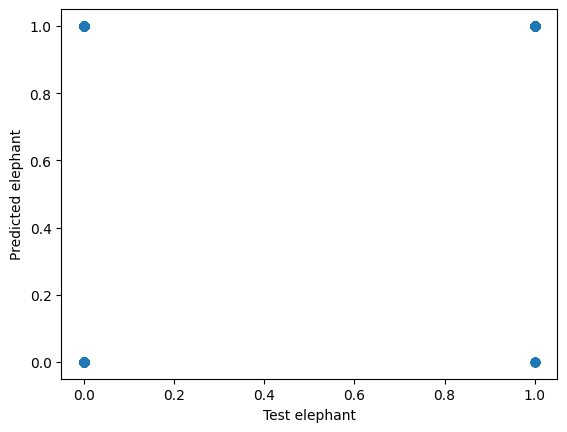

In [31]:
fig, ax = plt.subplots()
ax.set_xlabel('Test ' + target[0])
ax.set_ylabel('Predicted ' + target[0])
ax.scatter(y_test, y_pred)

(array([394353.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  59540.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

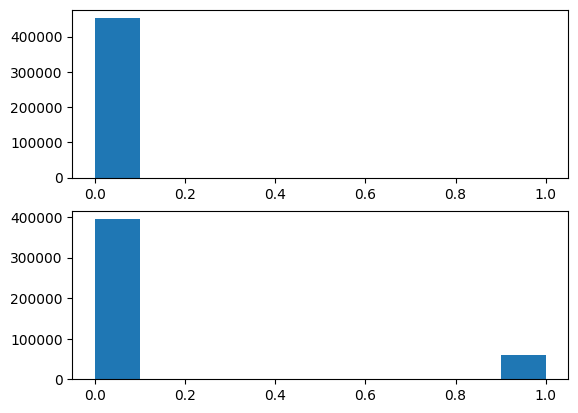

In [32]:
fig, ax = plt.subplots(2)
ax[0].hist(y_test)
ax[1].hist(y_pred)

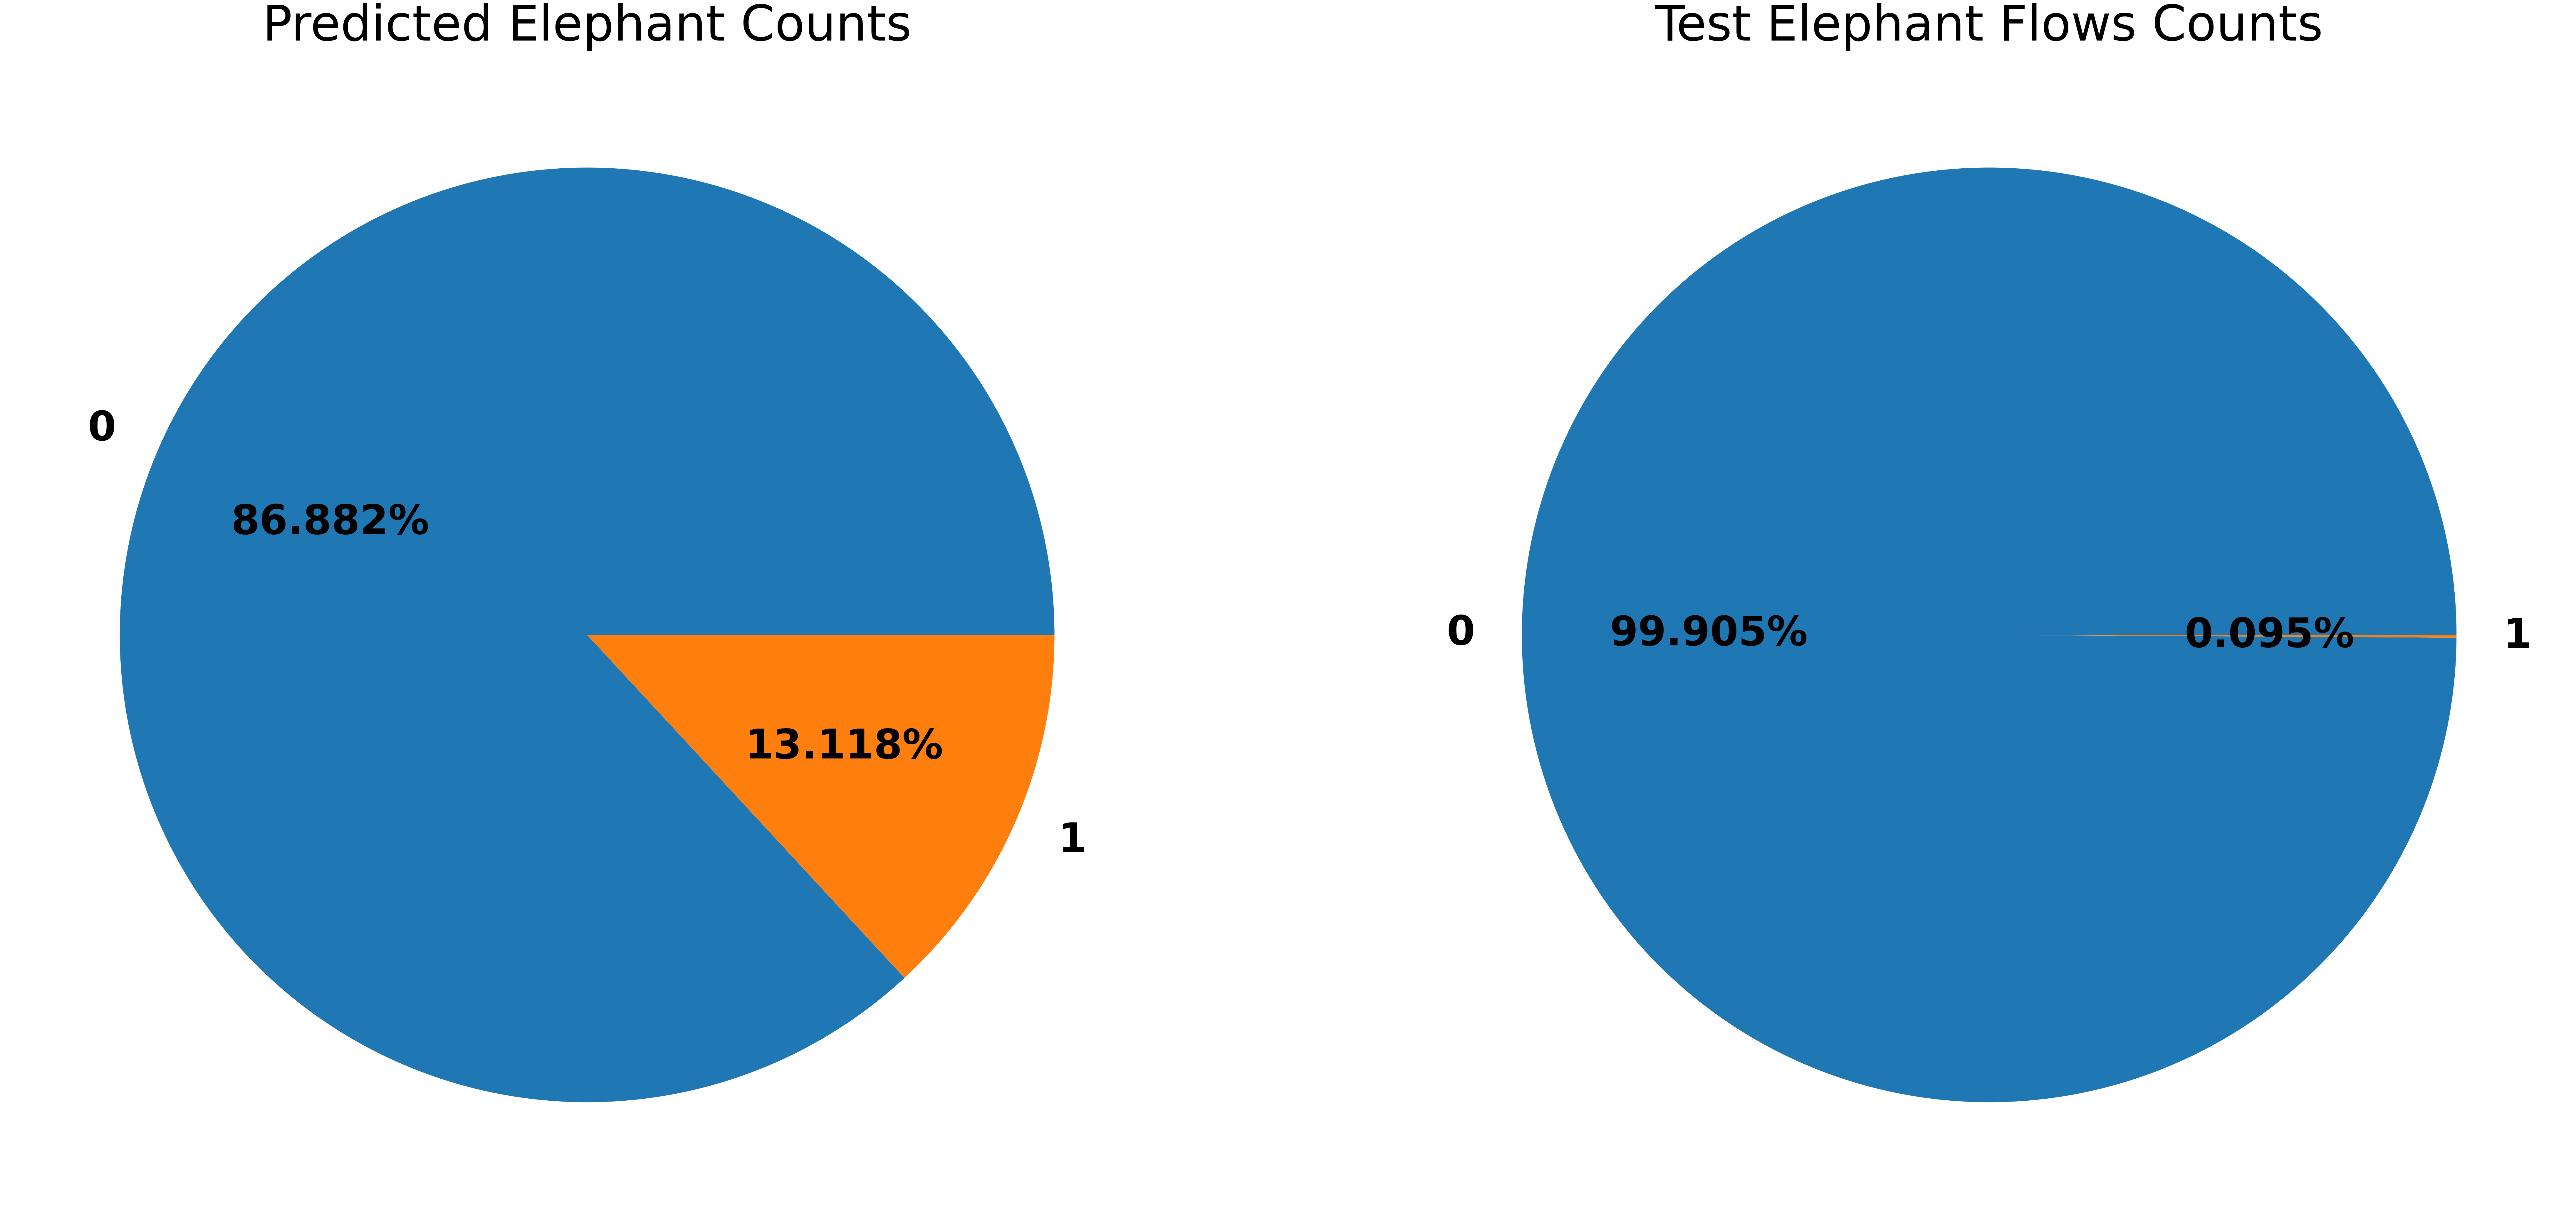

In [48]:
predictions = pd.DataFrame(y_pred)
testset = pd.DataFrame(y_test)

# get the set of distinct classes
labels_pred = predictions[0].unique()
labels_test = testset.elephant.unique()

# get the count of each class
sizes_pred = predictions[0].value_counts().values
sizes_test = testset.elephant.value_counts().values

font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 100}

matplotlib.rc('font', **font)

# plot the class value counts
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(100, 100))
plt.subplots_adjust(bottom=0.1, right=1, top=0.5)

ax[0].pie(sizes_pred, labels=labels_pred, autopct='%1.3f%%')
ax[0].set_title('Predicted Elephant Flows Counts')

ax[1].pie(sizes_test, labels=labels_test, autopct='%1.3f%%')
ax[1].set_title('Test Elephant Flows Counts')

plt.show()

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, y_pred, labels=[1,0]))

[[   408     24]
 [ 59132 394329]]


Confusion matrix, without normalization
[[   408     24]
 [ 59132 394329]]


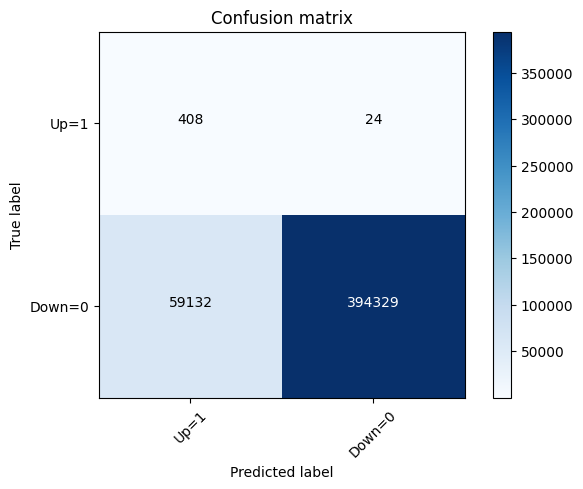

In [36]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Up=1','Down=0'], normalize=False, title='Confusion matrix')